# LSI and Scikit-Learn
    Matthew Mella
    10/16/23

In [3]:
import os
import string
import numpy as np
import sklearn
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

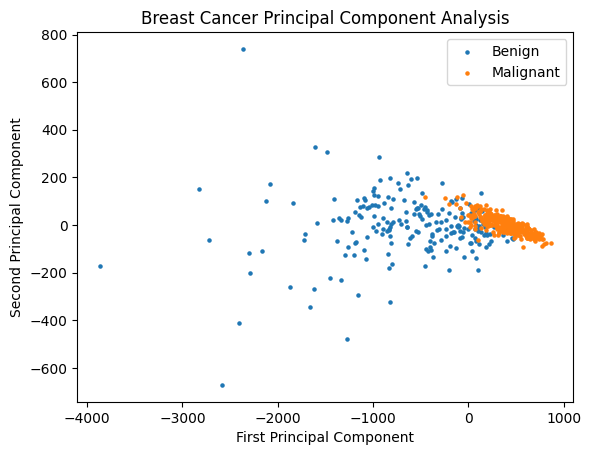

In [120]:
def prob1():
    """Recreate the plot in Figure 1 by performing PCA on the breast 
    cancer dataset. Translate the columns of X to have mean 0.
    Include the amount of variance captured by the first two principal 
    components in the graph title."""
    # load cancer data
    cancer = sklearn.datasets.load_breast_cancer()
    X = cancer.data
    y = cancer.target # Class labels (0 or 1)
    # shift the mean, perform svd
    Y = X - X.mean(axis=0)
    _,_,V_T = np.linalg.svd(Y)
    Y_hat = Y@V_T.T[:,:2]

    # plot benign and malignant
    benign = Y_hat[y == 0]
    malignant = Y_hat[y == 1]
    plt.scatter(benign[:, 0], benign[:, 1], s=5, label="Benign")
    plt.scatter(malignant[:, 0], malignant[:, 1], s=5, label="Malignant")
    plt.title("Breast Cancer Principal Component Analysis")
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.legend()
    plt.show()

prob1()

## Problem 2
Implement the function similar()

In [1]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components 
    of a document and returns two indices: the index of the document 
    that is least similar and the index of the document that is most 
    similar to i.
    
    Parameters:
        i: index of a document
        Xhat: decomposed data
    
    Returns:
        index_min: index of the document least similar to document i
        index_max: index of the document most similar to document i
    """
    # select a single doc
    doc = Xhat[i]
    # multiply xhat by the doc
    inner = Xhat@doc
    # find the least and most similar documents
    norms = np.linalg.norm(Xhat, axis=1)
    cosine_similarity =  np.argsort(inner / (norms*np.linalg.norm(doc)))
    
    return cosine_similarity[-2], cosine_similarity[0]


In [47]:
# Test case
X = np.array([
    [0.78, 0.14, 0.12, 0.  ],
    [0.64, 0.97, 0.  , 0.  ],
    [0.  , 0.  , 0.63, 0.46],
    [0.  , 0.84, 0.6 , 0.  ],
    [0.29, 0.89, 0.51, 0.  ],
    [0.77, 0.  , 0.27, 0.2 ],
    [0.86, 0.47, 0.  , 0.06],
    [0.89, 0.  , 0.  , 0.  ]
]) 
print(similar(4, X))

(3, 7)


### Function for Problem 3

In [52]:
def document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents.
    
    Returns:
        X ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = sorted([folder+p for p in os.listdir(folder) if p.endswith(".txt")])

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, storing counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)
              
    # Create sparse matrix holding these word counts.
    X = sparse.csr_array((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [90]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 
    principal components to find the most similar and least similar 
    speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    # save the sparse matrix and the list of speeches from document_converter()
    X, speech_list = document_converter()
    idx = speech_list.index(speech)

    # perform SVD on sparse matrix
    _,_,V = spla.svds(X, random_state=28)

    # create Xhat with l principle components
    Xhat = X@V.T[:,:l]

    # call similar() to get the most and least similar speeches
    most, least = similar(idx, Xhat)    

    return speech_list[most].split('/')[2].split('.')[0], speech_list[least].split('/')[2].split('.')[0]

In [88]:
# Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '2002-GWBush')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [4]:
# Problem 4
# Calculate global weights
def weighted_document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
        A ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # save the sparse X and the row paths
    X, paths = document_converter()
    m = len(paths)
    
    # find the matrix p_ij by dividing each row sum from each row
    p_arr = X / X.sum(axis=1)[:, np.newaxis]

    print(X.sum(axis=1).shape)
    print(X.sum(axis=1)[:, np.newaxis].shape)
    

    # set up the array to take the sum from 1 to m
    p_sum = (p_arr * np.log1p(p_arr)) / m

    g_arr = 1 + p_sum.sum(axis=1)

    return np.log1p(X) * g_arr[:, np.newaxis], paths

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [153]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with 
    the first 7 principal components to find the most similar and least 
    similar speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    # save the sparse matrix and the list of speeches from document_converter()
    X, speech_list = weighted_document_converter()
    idx = speech_list.index(speech)

    # Create a SVD model with l components
    svd = TruncatedSVD(random_state=74, n_components=l)

    # Fit the data
    svd.fit(X)

    # Multiply X by V[:,:l]
    Xhat = X@svd.components_.T[:,:l]

    # call similar() to get the most and least similar speeches
    most, least = similar(idx, Xhat)    

    return speech_list[most].split('/')[2].split('.')[0], speech_list[least].split('/')[2].split('.')[0]

In [152]:
# Run this box after you have completed prob5()
speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

('1992-Bush', '1946-Truman')
('1985-Reagan', '1946-Truman')


## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [122]:
# load the cancer data and split for training and testing
cancer = sklearn.datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# create classifiers, train and predict the test data
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

# print the classification reports
print("Random Forest Classifier Classification Report:")
print(classification_report(y_test, rfc_predicted))

print("KNeighbors Classifier Classification Report:")
print(classification_report(y_test, knn_predicted))

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        56
           1       0.97      0.95      0.96        87

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143

KNeighbors Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        56
           1       0.93      0.94      0.94        87

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



In this case, it is a lot more important that we we avoid false negatives than give false positives. For that reason, recall is more important. Thus, we should choose the model that has the best malignant 

## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [8]:
# load cancer data, split it for training and testing

cancer = sklearn.datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# create random forest classifier and params
rfc = RandomForestClassifier()
param_grid = {
    "min_samples_leaf": list(range(1,10)),
    "max_depth": [i * 10 for i in range(1,10)],
    "criterion": ["gini", "entropy", "log_loss"]
}
# do grid search on params
rfc_gs = GridSearchCV(rfc, param_grid, scoring="f1", n_jobs=-1)

# train the data, predict with the best estimator
rfc_gs.fit(X_train, y_train)

rfc_gs_predicted = rfc_gs.best_estimator_.predict(X_test)

print("best params: ",rfc_gs.best_params_)
print("best score: ", rfc_gs.best_score_)
print("Confusion Matrix, Random Forest Classifier Classification - Grid Search:")
print(confusion_matrix(y_test, rfc_gs_predicted))

best params:  {'criterion': 'entropy', 'max_depth': 80, 'min_samples_leaf': 3}
best score:  0.9743393904550214
Confusion Matrix, Random Forest Classifier Classification - Grid Search:
[[51  5]
 [ 4 83]]


## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least 0.96

In [9]:
# load cancer data, split it for training and testing
cancer = sklearn.datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# create pipeline and params
pipe = Pipeline([('StandardScaler', StandardScaler()),
                  ('PCA', PCA()),
                  ('KNeighborsClassifier', KNeighborsClassifier())])

pipe_param_grid = {
    'StandardScaler__with_mean': [True, False],
    'PCA__n_components': list(range(1,6)),
    'PCA__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
    'KNeighborsClassifier__n_neighbors': list(range(2,8)),
    'KNeighborsClassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'KNeighborsClassifier__leaf_size': list(range(10,60,10)),
    'KNeighborsClassifier__p': list(range(1,6)),
    'KNeighborsClassifier__weights': ['uniform', 'distance']
}

# perform pipeline gridsearch
pipe_gs = GridSearchCV(pipe, pipe_param_grid,
                       scoring="f1", n_jobs=-1).fit(X_train, y_train)

In [10]:
# print the best params and the score
print("best params: ",pipe_gs.best_params_)
print("best score: ", pipe_gs.best_score_)

best params:  {'KNeighborsClassifier__algorithm': 'auto', 'KNeighborsClassifier__leaf_size': 10, 'KNeighborsClassifier__n_neighbors': 7, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'uniform', 'PCA__n_components': 5, 'PCA__svd_solver': 'auto', 'StandardScaler__with_mean': True}
best score:  0.9782136765623004
